In [1]:
import os
import flopy
import numpy as np
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf
from ipywidgets import interact
from flopy.utils.gridgen import Gridgen

In [2]:
Lx = 10000.
Ly = 10500.
nlay = 3
nrow = 21
ncol = 20
delr = Lx/ncol
delc = Ly/nrow
top = np.ones((nrow, ncol), dtype=np.int32)
for i in range(ncol):
    top[:,i] = 396-i*4
botm = [220,200,0]

ms = flopy.modflow.Modflow()
dis = flopy.modflow.ModflowDis(ms, nlay=nlay, nrow=nrow, ncol=ncol, delr=delr,
                               delc=delc, top=top, botm=botm)

In [3]:
model_name = 'Ex04'
model_ws = 'Results'
gridgen_ws = os.path.join(model_ws, 'gridgen')
if not os.path.exists(gridgen_ws):
    os.mkdir(gridgen_ws)

#cant find gridgen executable in system; had to download the compiled file (for linux) from https://github.com/MODFLOW-USGS/executables
g = Gridgen(dis, model_ws=gridgen_ws, exe_name='/home/harsh/Desktop/modflow_flopy/flopyCourse/gridgen')

In [4]:
g.build(verbose=False)

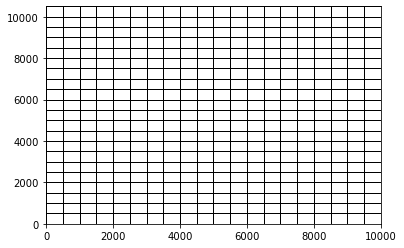

In [5]:
g.plot()

In [6]:
rf0shp = os.path.join(gridgen_ws, 'rf0')
xmin = 7*delr
xmax = 12*delr
ymin = 8*delc
ymax = 13*delc
rfpoly = [[[(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax), (xmin, ymin)]]]
g.add_refinement_features(rfpoly, 'polygon', 1, range(nlay))
g.build(verbose=False)

rf1shp = os.path.join(gridgen_ws, 'rf1')
xmin = 8*delr
xmax = 11*delr
ymin = 9*delc
ymax = 12*delc
rfpoly = [[[(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax), (xmin, ymin)]]]
g.add_refinement_features(rfpoly, 'polygon', 2, range(nlay))
g.build(verbose=False)

rf2shp = os.path.join(gridgen_ws, 'rf2')
xmin = 9*delr
xmax = 10*delr
ymin = 10*delc
ymax = 11*delc
rfpoly = [[[(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax), (xmin, ymin)]]]
g.add_refinement_features(rfpoly, 'polygon', 3, range(nlay))
# g.build(verbose=False)
# g.plot()

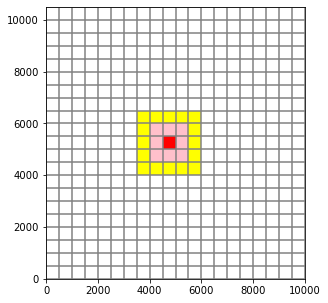

In [7]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1, aspect='equal')
mm = flopy.plot.PlotMapView(model=ms)
mm.plot_grid()
flopy.plot.plot_shapefile(rf0shp, ax=ax, facecolor='yellow', edgecolor='none')
flopy.plot.plot_shapefile(rf1shp, ax=ax, facecolor='pink', edgecolor='none')
flopy.plot.plot_shapefile(rf2shp, ax=ax, facecolor='red', edgecolor='none')


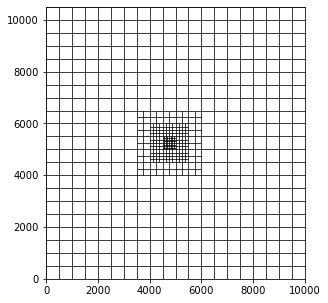

In [8]:
g.build(verbose=False)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1, aspect='equal')
g.plot(ax, linewidth=0.5)

In [11]:
gridprops = g.get_gridprops_disv()

ncpl = gridprops['ncpl']
top = gridprops['top']
botm = gridprops['botm']
nvert = gridprops['nvert'] #no of vertices
vertices = gridprops['vertices'] #vertex no and coordinate
cell2d = gridprops['cell2d'] #info about 2d cells

In [12]:
#using griddata generated using mf5 in creating mf6 simulation
sim = flopy.mf6.MFSimulation(sim_name=model_name, version='mf6', exe_name='/home/harsh/Desktop/modflow_flopy/flopyCourse/mf6', sim_ws=model_ws)

In [13]:
tdis_rc = [(1000., 1, 1)]
tdis = flopy.mf6.ModflowTdis(sim, pname='tdis', time_units='days', perioddata=tdis_rc)

In [14]:
gwf = flopy.mf6.ModflowGwf(sim, modelname=model_name, save_flows=True)

In [15]:
ims = flopy.mf6.ModflowIms(sim, outer_maximum=100, inner_maximum=100, linear_acceleration='BICGSTAB')

In [16]:
disv = flopy.mf6.ModflowGwfdisv(gwf, nlay=nlay, ncpl=ncpl, top=top, botm=botm, nvert=nvert,
                               vertices=vertices, cell2d=cell2d)

In [17]:
ic = flopy.mf6.ModflowGwfic(gwf, strt=320)

In [18]:
npf = flopy.mf6.ModflowGwfnpf(gwf, xt3doptions=[('xt3d')],
                             save_specific_discharge=True,
                             icelltype=[1,0,0],
                             k=[50.0, 0.01, 200.0],
                             k33=[10., 0.01, 20.])

In [19]:
wellpoints = [(4750., 5250.)]
welcells = g.intersect(wellpoints, 'point', 0)
welspd = [[(2,icpl), -150000, 0] for icpl in welcells['nodenumber']]
wel = flopy.mf6.ModflowGwfwel(gwf, auxiliary=[('iface',)], stress_period_data=welspd)

In [20]:
aux = [np.ones(ncpl, dtype=np.int32)*6]
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=0.005, auxiliary=[('iface',)], aux={0:[6]})

[<AxesSubplot:title={'center':' riv_0 location stress period 1 layer 1'}>,
 <AxesSubplot:title={'center':' riv_0 location stress period 1 layer 2'}>,
 <AxesSubplot:title={'center':' riv_0 location stress period 1 layer 3'}>]

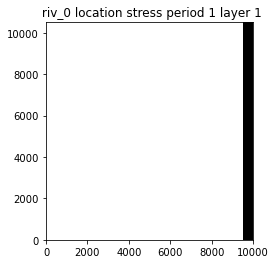

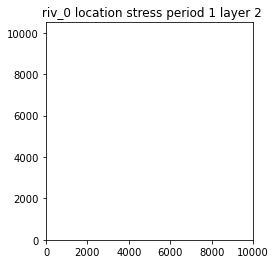

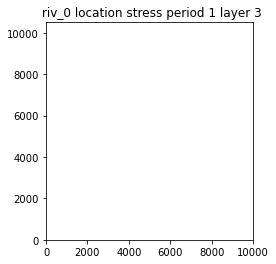

In [21]:
riverline = [[[(Lx-1, Ly), (Lx-1, 0)]]]
rivcells = g.intersect(riverline, 'line', 0)
rivspd = [[(0,icpl), 320, 100000, 318] for icpl in rivcells['nodenumber']]
riv = flopy.mf6.ModflowGwfriv(gwf, stress_period_data=rivspd)
riv.plot()

In [22]:
hname = '{}.hds'.format(model_name)
cname = '{}.cbc'.format(model_name)
oc = flopy.mf6.ModflowGwfoc(gwf, budget_filerecord=cname, head_filerecord=hname,
                           saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])

sim.write_simulation()
sim.run_simulation()


writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims_-1...
  writing model Ex04...
    writing model name file...
    writing package disv...
    writing package ic...
    writing package npf...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package rcha...
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 21 based on size of stress_period_data
    writing package oc...
FloPy is using the following  executable to run the model: /home/harsh/Desktop/modflow_flopy/flopyCourse/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.1 02/18/2021

  MODFLOW 6 compiled May  4 2021 17:51:29 with GFORTRAN compiler (ver. 9.3.0)

This software has been approved for release by the U.S. Geological 

(True, [])

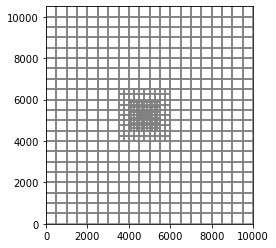

In [24]:
fname = os.path.join(model_ws, model_name+'.disv.grb')
grd = flopy.utils.MfGrdFile(fname, verbose=False)
iverts, vert = grd.get_verts()
vertc = grd.get_centroids()
mf = grd.get_modelgrid()
mf.plot()

In [26]:
fname = os.path.join(model_ws, model_name+'.hds')
hdobj = flopy.utils.HeadFile(fname)
head = hdobj.get_data()
head.shape

(3, 1, 651)

<a list of 4 text.Text objects>

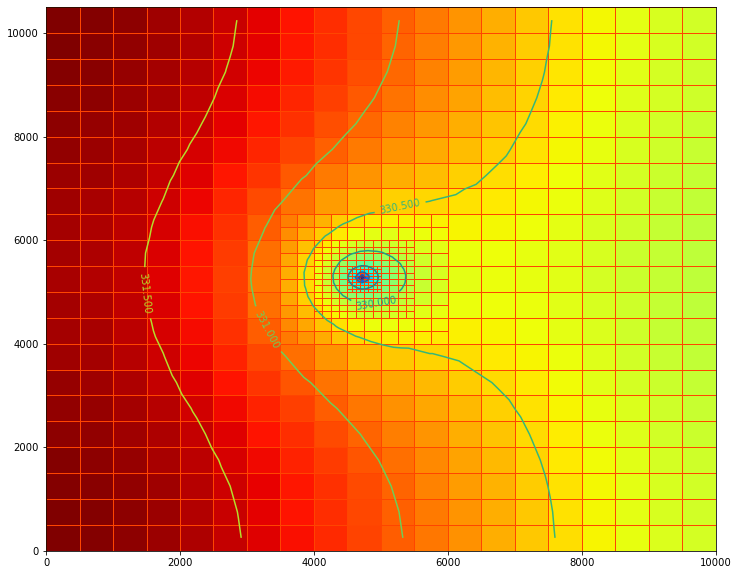

In [31]:
fig, ax = plt.subplots(figsize=(12,10))
mm = flopy.plot.PlotMapView(modelgrid=mf, ax=ax)
ax.set_xlim(0, Lx)
ax.set_ylim(0, Ly)

v = mm.plot_cvfd(vert, iverts, edgecolor='orangered', a=head[2,0,:], cmap='jet')

cs = mm.contour_array_cvfd(vertc, head[2,0,:])
plt.clabel(cs)